# Imports & Constants

In [24]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import numpy as np
import shutil
import time
import json
from time import sleep
from datetime import datetime
import re



def extract_time_format_from_datetime(formatted_time):
    if("T" in formatted_time):
      formatted_time = formatted_time.split("+")[0]
      formatted_time = formatted_time.replace("T", " ")
      return "%Y-%m-%dT%H:%M:%S"
    return "%Y-%m-%d %H:%M:%S.%f"
def convert_datetime_to_time_since_last_epoch(formatted_time):
    time_format = extract_time_format_from_datetime(formatted_time)
    time_struct = time.strptime(formatted_time, time_format)
    datetime_obj = datetime.fromtimestamp(time.mktime(time_struct))
    return datetime_obj.timestamp()

# Most recent directory
galaxy_watch_folder_dirs = os.listdir("./data/galaxywatch/")
galaxy_watch_folder_dirs.sort()
galaxy_watch_folder_dir = "./data/galaxywatch/"+galaxy_watch_folder_dirs[-1] + "/"
exercise_logs_folder_dir = "./data/exerciselogs/"
computer_usage_folder_dir = "./data/computerusage/"
calendar_events_folder_dir = "./data/calendar/2023-10-31"


# No data filter
# data_start_time = 0

# First day of college 
data_end_time = 9e50
data_start_time = 0

# 3 weeks out
data_start_time = round(convert_datetime_to_time_since_last_epoch("2023-9-4 00:00:00.0"))
# data_end_time = round(convert_datetime_to_time_since_last_epoch("2023-10-30 23:59:00.0"))
# data_end_time, data_start_time

if data_end_time >= 9e20:
  data_end_time = time.time()


# Data Management

In [ ]:
# Check to see if there is any new data (from my android phone)
# Define the source and destination directories
src_dir = "/run/user/1000/gvfs/mtp:host=motorola_motorola_one_5G_ace_ZY22DDHW4G/Internal shared storage/Download/Samsung Health"
dest_dir = "./data/galaxywatch"

# Loop through all the directories in the source directory
for dir_name in os.listdir(src_dir):
    # Check if the item is a directory
    if os.path.isdir(os.path.join(src_dir, dir_name)):
        # Check if the directory already exists in the destination directory
        if not os.path.exists(os.path.join(dest_dir, dir_name)):
            # If it doesn't exist, copy it over
            shutil.copytree(os.path.join(src_dir, dir_name), os.path.join(dest_dir, dir_name))

In [ ]:
# Clean up the data a but
dest_dir = "./data/galaxywatch/"
for dir_name in os.listdir(dest_dir):
    folder_dir = f"{dest_dir}/{dir_name}/"

    # Do some cleaning on the folder data
    date_time_of_upload = folder_dir.split("_")[-1][:-1]

    # Rename all of the files so that they are easier to deal with
    for file_name in os.listdir(folder_dir):
        if os.path.isdir(folder_dir + file_name):
            continue
        if "com.samsung" not in file_name:
            continue
        new_file_name = file_name.replace(".".join(file_name.split(
            ".")[:3]) + ".", "").replace(date_time_of_upload + ".", "")
        os.rename(folder_dir + file_name, folder_dir + new_file_name)

    # Clean csv's so that they dont have that first line with junk
    for file_name in os.listdir(folder_dir):
        if os.path.isdir(folder_dir + file_name):
            continue
        file_text = ""
        with open(folder_dir + file_name, "r") as f:
            file_text = f.read()

            if "com.samsung" in (file_text.split("\n")[0]):
                file_text = "\n".join(file_text.split("\n")[1:])
                with open(folder_dir + file_name, "w") as f:
                    f.write(file_text)


# Helper functions

In [31]:
def compute_correlation(df_1, df_2, x_axis, y_axies):
    # Convert the "date" column to a datetime type
    if x_axis == "date":
        df_1[x_axis] = pd.to_datetime(df_1[x_axis])
        df_2[x_axis] = pd.to_datetime(df_2[x_axis])

    # Merge the sleep and computer usage DataFrames on the date column
    if x_axis != "index":
        merged_df = pd.merge(df_1, df_2, on=x_axis)
    else:
        merged_df = pd.merge(df_1, df_2, on="date")

    # Compute the correlation between "last_time_used" and "sleep_amount"
    correlation = merged_df[y_axies[0]].corr(merged_df[y_axies[1]])
    return correlation


def average_series(series_1, series_2):
    new_series = pd.Series(dtype=pd.Float64Dtype)
    for column in series_1.index:
        if type(series_1[column]) == str:
            continue
        new_series[column] = (series_1[column] + series_2[column]) / 2
    return new_series

# Define a function to find the closest weight entry in fitdays_data for a given row in shealth_data


def average_measurements_that_are_close_in_time(dataframe: pd.DataFrame, time_column_name, group_1_function, group_2_function, time_difference_threshold, mode="mean"):
    # Calculate the time difference between the current row and all rows in fitdays_data

    group_1_dataframe = group_1_function(dataframe)
    group_2_dataframe = group_2_function(dataframe)

    group_1_dataframe = group_1_dataframe.sort_values(by=time_column_name)
    group_2_dataframe = group_2_dataframe.sort_values(by=time_column_name)

    new_dataframe = pd.DataFrame(columns=group_1_dataframe.columns)

    # for each entry in the group_1_dataframe, find the neastest entry in time
    for (index, row) in group_1_dataframe.iterrows():
        candidates = (group_2_dataframe[abs(
            group_2_dataframe[time_column_name] - row[time_column_name]) < time_difference_threshold])
        if candidates.shape[0] == 0:
            continue

        match mode:
            case "mean":
                another_row = average_series(candidates.iloc[0], row)
                new_dataframe = pd.concat(
                    [new_dataframe, another_row.to_frame().T], ignore_index=True)

    return new_dataframe


def plot_variables(df, x_axis_column_name, y_axis_column_names, y_axis_visible, title, image_name="plot.png", convert_to_date=False):

  if (len(y_axis_column_names) < 2):
     print("Warning: only the you have only passed in 1 variable to plot")

  color_hex_codes = ['#FF5733', '#40E0D0', '#4169E1', '#32CD32',
      '#FFD700', '#DA70D6', '#FF7F50', '#708090', '#FF1493', '#008B8B']

  axes = []
  fig, ax1 = plt.subplots(figsize=(16, 9))
  ax2 = ax1.twinx()

  axes = [ax1, ax2]

  if len(y_axis_column_names) > 2:
    for i in range(2, len(y_axis_column_names)):
      axes.append(axes[i % 2].twinx())
  elif len(y_axis_column_names) == 2:
    # Label the axes with the two different column names
    axes[0].set_ylabel(
        convert_snake_case_to_pascal_case(y_axis_column_names[0]))
    axes[1].set_ylabel(
        convert_snake_case_to_pascal_case(y_axis_column_names[1]))
  else:
     axes[0].set_ylabel(
         convert_snake_case_to_pascal_case(y_axis_column_names[0]))
  for ax, column_name in zip(axes, y_axis_column_names):
    random.seed(69)
    color = random.choice(color_hex_codes)
    color_hex_codes.remove(color)
    print(column_name, " is ", color)
    ax.plot(df[x_axis_column_name], df[column_name],
            label=column_name, color=color)

    ax.get_yaxis().set_visible(y_axis_visible)
    plt.legend()

  if convert_to_date or "date" in x_axis_column_name:
    convert_time_since_last_epoch_x_axis_to_date(ax)
  plt.title(title)
  savefig(title)
  plt.show()


def savefig(title="", image_name="plot.png", type_="plot"):
    if title == "" and image_name == "plot.png":
      raise Exception("You must pass in a title or an image name")
    if title != "":
      image_name = type_ + "_for_" + to_snake_case(title)+ ".png"
    plt.savefig(f"./figs/{image_name}")
    

def convert_time_since_last_epoch_to_date(time_since_last_epoch):
    time_struct = time.localtime(time_since_last_epoch)
    datetime_obj = datetime.fromtimestamp(time.mktime(time_struct))
    return datetime_obj.strftime("%Y/%m/%d")

def convert_snake_case_to_pascal_case(snake_case_string):
    return "".join([word.capitalize() for word in snake_case_string.split("_")])

def extract_time_format_from_datetime(formatted_time:str):
    if formatted_time.count(":") < 1:
      return "%Y-%m-%d"
    elif "T" in formatted_time:
      formatted_time = formatted_time.split("+")[0]
      formatted_time = formatted_time.replace("T", " ")
      return "%Y-%m-%dT%H:%M:%S"
    return "%Y-%m-%d %H:%M:%S.%f"
def convert_datetime_to_time_since_last_epoch(formatted_time):
    formatted_time = formatted_time.replace("/", "-")
    time_format = extract_time_format_from_datetime(formatted_time)
    time_struct = time.strptime(formatted_time, time_format)
    datetime_obj = datetime.fromtimestamp(time.mktime(time_struct))
    return datetime_obj.timestamp()
def apply_conversion_to_muliple_columns(dataframe, column_names, conversion: float):
    if type(conversion) == list:
        raise Exception("muliptle conversions not implemented yet")

    for column in column_names:
        dataframe[column] = dataframe[column].apply(lambda x: float(x) * conversion)
    return dataframe

def convert_time_since_last_epoch_x_axis_to_date(ax):
  labels = ax.get_xticklabels()
  # Define the new x-axis tick labels
  new_labels = [convert_time_since_last_epoch_to_date(float(label.get_text()) * 1e9) for label in labels]
  
  # Set the new x-axis tick labels
  ax.set_xticklabels(new_labels)

def convert_utc_offset_to_hours(utc_offset):
  example = "UTC-05:00"
  return int(utc_offset.split("-")[1][:2])

def remove_columns(dataframe, columns):
  return dataframe.drop(columns=columns)

weekday_int_to_day = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
def convert_datetime_to_weekday(dataframe, column_name, weekday_int_to_day = False):
  if(weekday_int_to_day):
    dataframe["day_of_the_week"] = dataframe[column_name].apply(lambda x: weekday_int_to_day[datetime.fromtimestamp(x).weekday()])
  else:
    dataframe["day_of_the_week"] = dataframe[column_name].apply(lambda x: datetime.fromtimestamp(x).weekday())
  return dataframe

def to_snake_case(string):
  return "_".join(string.split(" ")).lower()

def clamp_dataframe_time(dataframe, time_name, start_time, end_time):
  return dataframe[(dataframe[time_name] >= start_time) & (dataframe[time_name] <= end_time)]

def plot_box_and_whisker(dataframe: pd.DataFrame, x_axis_column_name, y_axis_column_name, title, x_axis_label, y_axis_label, image_name="box_and_whisker.png"):
  if(image_name == "box_and_whisker.png"):
    image_name = image_name.replace(".png", "_for_") + to_snake_case(title) + ".png" 
  axes = dataframe.boxplot(column=y_axis_column_name, by=x_axis_column_name, return_type='axes', figsize=(16, 9))
  axes = (axes[y_axis_column_name])
  
  axes.set_xlabel(x_axis_label)
  axes.set_ylabel(y_axis_label)
  axes.set_title(title)

  # Get the current x-axis tick labels
  # labels = axes.get_xticklabels()
  if x_axis_column_name == "day_of_the_week":
    new_labels = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    
    # Set the new x-axis tick labels
    axes.set_xticklabels(new_labels)

  plt.savefig(f"./figs/{image_name}")
  plt.show()


def plot_scatter(dataframe, x_axis_column_name, y_axis_column_name):
  dataframe.plot.scatter(x=x_axis_column_name, y=y_axis_column_name)
  plt.show()

def compute_r_squared(x, y, m, b):
  # Compute the residuals
  y_pred = m*x + b
  residuals = y - y_pred

  # Compute the mean of the residuals
  mean_residuals = np.mean(residuals)

  # Compute the total sum of squares
  total_sum_squares = np.sum((y - mean_residuals)**2)

  # Compute the residual sum of squares
  residual_sum_squares = np.sum(residuals**2)

  # Compute the R-squared
  r_squared = 1 - (residual_sum_squares / total_sum_squares)
  return r_squared

# Plot the line of best fit for the data
def plot_line_of_best_fit(dataframe, x_axis_column_name, y_axis_column_name, title, x_axis_label, y_axis_label, image_name = "line_of_best_fit.png"):
  if(image_name == "line_of_best_fit.png"):
    image_name = image_name.replace(".png", "_for_") + to_snake_case(title) + ".png" 
  x = dataframe[x_axis_column_name]
  y = dataframe[y_axis_column_name]
  m, b = np.polyfit(x, y, 1)
  fig, ax = plt.subplots(figsize=(16, 9))
  ax.set_title(title)
  ax.set_xlabel(x_axis_label)
  ax.set_ylabel(y_axis_label)
  ax.plot(x, y, '.', label="data")
  ax.plot(x, m*x + b, '-', label="line of best fit")
  print(m)
  # label the slope of the line in minutes/day
  # Calculate the position of the annotation
  x_pos = 0.5  # Adjust this value to move the annotation along the x-axis
  y_pos = m * x_pos + b  # This will place the annotation on the line of best fit

  # Create the annotation
  ax.annotate(f"{round(m * 3600 * 24 * 60, 5)} minutes/day", 
              xy=(x_pos, y_pos), 
              xytext=(20, 20), 
              textcoords='offset points', 
              arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=7),
              fontsize=12, 
              color='red', 
              ha='center')


  if "date" not in x_axis_column_name:
    convert_time_since_last_epoch_x_axis_to_date(ax)
  ax.legend()
  plt.savefig(f"./figs/{image_name}")
  plt.show()


def do_the_rudamentary_time_changes(dataframe: pd.DataFrame, use_end_time_for_date = False):
    columns_to_convert_to_time_since_last_epoch = ["start_time", "end_time"]

    if "time_offset" in dataframe.columns:
      dataframe["time_offset"] = convert_utc_offset_to_hours(dataframe["time_offset"].iloc[0])
    else:
      dataframe["time_offset"] = 0
    for column in columns_to_convert_to_time_since_last_epoch:
        if column in dataframe.columns and type(dataframe[column].iloc[0]) == str:
          dataframe[column] = dataframe[column].apply(convert_datetime_to_time_since_last_epoch) - dataframe["time_offset"] * 3600

    dataframe = dataframe.sort_values(by="start_time")
    if "end_time" in dataframe.columns:
      dataframe = convert_datetime_to_weekday(dataframe=dataframe, column_name="end_time")
    elif "start_time" in dataframe.columns:
      dataframe = convert_datetime_to_weekday(dataframe=dataframe, column_name="start_time")
      
    dataframe = clamp_dataframe_time(dataframe, "start_time", data_start_time, data_end_time)
    if not use_end_time_for_date:
      dataframe["date"] = dataframe["start_time"].apply(convert_time_since_last_epoch_to_date)
    else:
      dataframe["date"] = dataframe["end_time"].apply(convert_time_since_last_epoch_to_date)
    return dataframe

def sum_df_by_variable(df: pd.DataFrame, x_axis, y_axies, modes):
    # Group computer usage events by date
    grouped = df.groupby(df[x_axis])

    if type(y_axies) == str:
        y_axies = [y_axies]

    if type(modes) == str:
        modes = [modes]
    if len(y_axies) > len(modes) and len(modes) == 1:
        modes = modes * len(y_axies)
    elif len(y_axies) < len(modes) and len(y_axies) == 1:
        y_axies = y_axies * len(modes)
    elif len(y_axies) != len(modes):
        raise Exception("y_axies and modes must be the same length")

    # Create new DataFrame with the total durations
    result_df = pd.DataFrame({
        # x_axis: grouped.groups,
    })
    for axis, mode in zip(y_axies, modes):
        match mode:
            case "mean":
                result_df[axis] = grouped[axis].mean()
            case "sum":
                result_df[axis] = grouped[axis].sum()
            case "max":
                result_df[axis] = grouped[axis].max()
            case "min":
                result_df[axis] = grouped[axis].min()
            case "first":
                result_df[axis] = grouped[axis].first()
            case _:
                raise Exception("Invalid mode")
    # if ""
    #     "last_time_used" : grouped["start_time"].max()
    # result_df["start_of_the_day"] = result_df["date"].apply(lambda x: str(x) + " 00:00:00.00").apply(convert_datetime_to_time_since_last_epoch)
    # result_df["last_time_used"] = (result_df["last_time_used"] - result_df["start_of_the_day"])  / 3600
    return result_df


# Weight

In [25]:
weight = pd.read_csv(galaxy_watch_folder_dir + "weight.csv", index_col=False)
# filter weight

# weight = weight[weight["pkg_name"].isin(["cn.fitdays.fitdays"])]
weight = weight[pd.notna(weight["body_fat_mass"])]
weight["start_time"] = weight["start_time"].apply(convert_datetime_to_time_since_last_epoch)
weight = weight.rename(columns = {"total_body_water" : "water_mass"})
weight = apply_conversion_to_muliple_columns(weight, ["body_fat_mass", "weight", "muscle_mass", "skeletal_muscle_mass", "fat_free_mass", "water_mass"], 2.2)
# weight = clamp_dataframe_time(weight, "start_time", data_start_time, data_end_time)

weight = do_the_rudamentary_time_changes(weight)


# For every weight entry that has a package name of "com.sec.android.app.shealth" find the closest weight entry from cn.fitdays.fitdays, make sure they are less than 7200 seconds apart

weight.drop(['custom', 'comment', "datauuid", "vfa_level", "deviceuuid", ], axis=1, inplace=True)
group_1_function = lambda df: df[df["pkg_name"] == "com.sec.android.app.shealth"]
group_2_function = lambda df: df[df["pkg_name"] == "cn.fitdays.fitdays"]
    
weight = average_measurements_that_are_close_in_time(weight, "start_time", group_1_function, group_2_function, 3600 * 12)

weight = weight.sort_values(by="start_time")
weight.sort_index(inplace=True)


In [29]:
# Create a rolling average calculation using the previous 7 days worth of data. If there is not any data within those 7 days
# then interpolate the data from other points

def create_rolling_average_dataframe(df: pd.DataFrame):
  '''
  The purpose of this function is that it will make a dataframe that is a rolling average of the input dataframe, but it will do that using the 
  df["start_time"] as the time since last epoch to make the rolling average calculations. This is useful because the data is not evenly spaced out
  '''
  rolling_average_df = pd.DataFrame()
  rolling_average_df["start_time"] = df["start_time"]
  rolling_average_df["rolling_average"] = df["weight"]
  # Create the date column from the starttime column
  rolling_average_df["date"] = rolling_average_df["start_time"].apply(convert_time_since_last_epoch_to_date)
  rolling_average_df.set_index("date", inplace=True)
  rolling_average_df.index = pd.to_datetime(rolling_average_df.index)
  rolling_average_df = rolling_average_df.resample('D').mean()

  # Calculate the rolling average before interpolating
  rolling_average_df["rolling_average"] = rolling_average_df["rolling_average"].rolling(7, min_periods=1).median()

  # Then interpolate the missing values
  rolling_average_df["rolling_average"] = rolling_average_df["rolling_average"].interpolate()
  
  # fill in the start_times for the new rolling averages
  rolling_average_df["start_time"] = rolling_average_df.index.map(lambda x: convert_datetime_to_time_since_last_epoch(str(x) + ".00"))

  # Find the slope of the rolling average to figure out weight loss per day
  rolling_average_df["rolling_average_slope"] = rolling_average_df["rolling_average"].diff()
  rolling_average_df["rolling_average_slope"] = rolling_average_df["rolling_average_slope"].rolling(7, min_periods=1).mean()


  return rolling_average_df

rolling_average_df = create_rolling_average_dataframe(weight)
# rolling_average_df = rolling_average_df.dropna()
rolling_average_df = rolling_average_df.sort_values(by="start_time")
rolling_average_df = rolling_average_df.reset_index(drop=True)
rolling_average_df.head(5)
rolling_average_df.shape[0]

60

-1.9184315336758667e-06


/tmp/ipykernel_802177/298989524.py:144: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


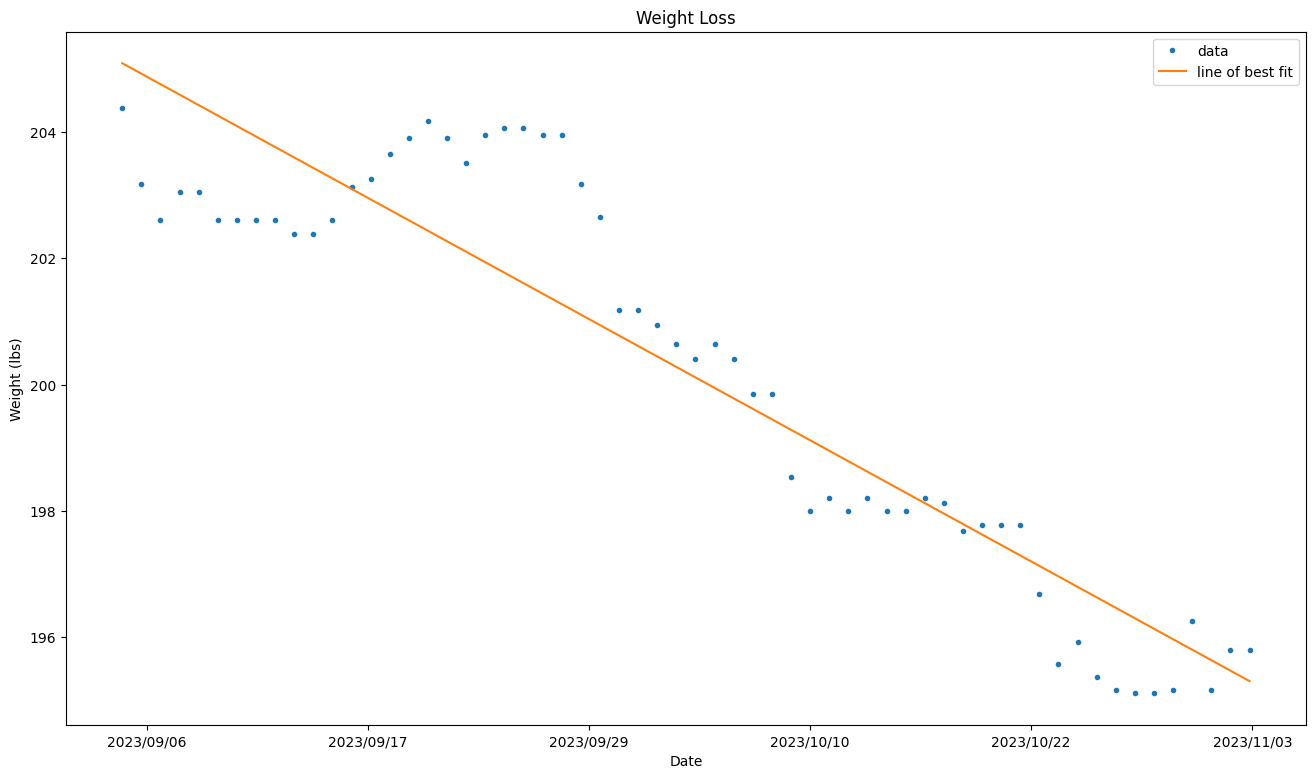

In [32]:
rolling_average_df
plot_line_of_best_fit(rolling_average_df, "start_time", "rolling_average", "Weight Loss", "Date", "Weight (lbs)")

In [ ]:
plot_variables(rolling_average_df, "start_time", ["rolling_average", "rolling_average_slope"], True, title="Weight vs. Time", convert_to_date=True)

## Sleep

In [ ]:

sleep = pd.read_csv(galaxy_watch_folder_dir + "sleep.csv", index_col=False)

columns_to_remove = ["comment", "datauuid", "custom","deviceuuid","pkg_name", "original_efficiency", "extra_data", "quality", "original_bed_time", "create_time", "update_time", "combined_id", "has_sleep_data", "sleep_type", "data_version"]
remove_prefix = lambda x: x.replace("com.samsung.health.sleep.", "")

# Remove columns from sleep

# Rename the columns using the lambda function
sleep = sleep.rename(columns=remove_prefix)
sleep = sleep.drop(columns=columns_to_remove)
sleep["sleep_duration"] = sleep["sleep_duration"].apply(lambda x: float(x) / 60)
# Change starttime so its local timzone
sleep = do_the_rudamentary_time_changes(sleep, use_end_time_for_date=True)

daily_sleep = sum_df_by_variable(sleep, "date", ["sleep_duration", "day_of_the_week", "start_time", "sleep_score", "efficiency", "mental_recovery", "physical_recovery"], ["sum", "first", "mean", "mean", "mean", "mean", "mean"])

In [ ]:
# Plot box and whisker chart for day of the week and amount slept

plot_box_and_whisker(daily_sleep, "day_of_the_week", "sleep_duration", "Sleep Duration vs Day of the Week", "Day of the Week", "Sleep Duration (hours)")
plot_box_and_whisker(daily_sleep, "day_of_the_week", "sleep_score", "Sleep Score vs Day of the Week", "Day of the Week", "Sleep Score (0-100)")
plot_box_and_whisker(daily_sleep, "day_of_the_week", "efficiency", "Sleep Efficiency vs Day of the Week", "Day of the Week", "Sleep Efficiency (0-100)")
plot_box_and_whisker(daily_sleep, "day_of_the_week", "mental_recovery", "Mental Recovery vs Day of the Week", "Day of the Week", "Mental Recovery (0-100)")
plot_box_and_whisker(daily_sleep, "day_of_the_week", "physical_recovery", "Physical Recovery vs Day of the Week", "Day of the Week", "Physical Recovery (0-100)")

In [ ]:
  
# plot_scatter(sleep, "com.samsung.health.sleep.start_time","sleep_duration")
plot_line_of_best_fit(daily_sleep, "start_time","sleep_duration", "Sleep Duration (hours) vs. Time", "Time", "Sleep Duration (hours)")


# Stress

In [ ]:
stress = pd.read_csv(galaxy_watch_folder_dir + "stress.csv", index_col=False)
stress = stress.rename(columns=remove_prefix)
columns_to_remove = ["custom",	"binning_data",	"tag_id",	"create_time",	"algorithm",	"deviceuuid",	"comment",	"pkg_name",	"datauuid"]
stress = stress.drop(columns=columns_to_remove)

stress = do_the_rudamentary_time_changes(stress)
stress["hour"] = stress["start_time"].apply(lambda x: datetime.fromtimestamp(x).hour)
stress.head(10)
daily_stress = sum_df_by_variable(stress, "date", ["score", "max", "min", "score", "day_of_the_week"], ["mean"])
daily_stress

In [ ]:
plot_box_and_whisker(daily_stress, "day_of_the_week", "score", "Stress Level vs Day of the Week", "Day of the Week", "Stress Level")
plot_box_and_whisker(daily_stress, "day_of_the_week", "max", "Peak Stress Level vs Day of the Week", "Day of the Week", "Stress Level")

In [ ]:
plot_box_and_whisker(stress, "hour", "score", "Stress Level vs Hour of the Day", "Hour of the Day", "Stress Level")

In [ ]:
def plot_matrix(dataframe: pd.DataFrame, x_axies, y_axis, title):
  # This function will be used to see the average stress given a specific hour and given a specific day
  assert len(x_axies) == 2
  fig, ax = plt.subplots(figsize=(16, 9))

  avg_stress = dataframe.groupby([x_axies[0], x_axies[1]])[y_axis].mean()

  # convert the resulting series to a matrix with days as rows and hours as columns
  matrix = avg_stress.unstack(level=1)
  
  im = ax.imshow(matrix, cmap="hot", interpolation="nearest")
  
  # convert the x axis into days of the week

  new_labels = ["","Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
  ax.set_yticklabels(new_labels)
  ax.set_xticklabels([""] + [str(z) + ":00" for z in range(6, 24, 2)])
  ax.set_title(title)
  
  colorbar = ax.figure.colorbar(im, ax=None)
  colorbar.set_label("Stress Level (0-100)")
  savefig(title, type_="matrix")

plot_matrix(stress[stress["hour"] > 6], ["day_of_the_week", "hour"], "score",  "Stress Correlation Matrix For Days of the Week vs. Hour of the Day")

# Computer Usage

In [ ]:
data = json.loads(open(computer_usage_folder_dir + "aw-bucket-export_aw-watcher-window_matts-computer.json").read())

In [ ]:
computer_usage_raw = pd.DataFrame(data["buckets"]["aw-watcher-window_matts-computer"]["events"])
computer_usage_raw["start_time"] = computer_usage_raw["timestamp"].apply(lambda string: string.split("+")[0].split(".")[0]).apply(convert_datetime_to_time_since_last_epoch) - 5 * 3600



computer_usage_raw["timestamp"] = computer_usage_raw["start_time"].apply(convert_time_since_last_epoch_to_date)
computer_usage_raw.sort_values(by="start_time",ascending=False )

computer_usage_raw = do_the_rudamentary_time_changes(computer_usage_raw)
computer_usage = sum_df_by_variable(computer_usage_raw, "date", ["duration", "day_of_the_week", "start_time"], ["mean", "first", "max"])
computer_usage["last_time_used"] = computer_usage["start_time"]
computer_usage["start_time"] = (computer_usage["start_time"]).apply(convert_time_since_last_epoch_to_date).apply(convert_datetime_to_time_since_last_epoch)
computer_usage["last_time_used"] = (abs(computer_usage["start_time"] - computer_usage["last_time_used"])) / 3600

## Computer Usage vs. Sleep

In [ ]:
compute_correlation(computer_usage, daily_sleep, "index", ["last_time_used", "sleep_score"])

In [ ]:
computer_usage["datetime"] = computer_usage["start_time"].apply(convert_time_since_last_epoch_to_date)
daily_sleep["datetime"] = daily_sleep["start_time"].apply(convert_time_since_last_epoch_to_date)

In [ ]:
merged = pd.merge(computer_usage, daily_sleep, on="datetime")
print(merged.head(5))
plot_variables(merged, "datetime", ["last_time_used", "sleep_score"], True, "Last Time Used vs. Sleep Score")

# Exercise

In [ ]:
exercise = pd.read_csv(galaxy_watch_folder_dir + "exercise.csv", index_col=False)
columns_to_remove = ["subset_data", "routine_datauuid", "activity_type", "title", "tracking_status", "source_type", "reward_status", "mission_extra_value", "program_schedule_id", "program_id", "mean_caloricburn_rate", "heart_rate_deviceuuid", "live_data_internal", "mission_value", "pace_info_id", "pace_live_data", "mission_type", "location_data_internal", "additional_internal", "min_altitude", "max_altitude", "deviceuuid","completion_status" , "comment", "location_data", "sensing_status", "incline_distance", "decline_distance", "live_data", "datauuid", "max_cadence", "altitude_gain", "update_time", "create_time"]
remove_prefix = lambda x: x.replace("com.samsung.health.exercise.", "")

exercise_type_number_to_string_map = {
  15002 : "Weight Lifting",
  1002 : "Running",
  1001 : "Walking",
  5001 : "Volleyball",
  11007 : "Cycling",
  0 : "UNKNOWN"
}

exercise = exercise.rename(columns=remove_prefix)

exercise = exercise.drop(columns = columns_to_remove)
exercise = do_the_rudamentary_time_changes(exercise)
print(exercise.head(10))
exercise["duration"] /= 1000

# use the exercise_type_number_to_string_map
exercise["exercise_type"] = exercise["exercise_type"].apply(lambda x: exercise_type_number_to_string_map[x])


## Exercise & Sleep

In [ ]:
# Find days when we go to the gym (weight lifting)

days_worked_out = exercise[exercise["exercise_type"] == "Weight Lifting"]["date"].unique()

print(daily_sleep.head(5))
daily_sleep["datetime"] = daily_sleep["start_time"].apply(convert_time_since_last_epoch_to_date)
daily_sleep["worked_out"] = daily_sleep["datetime"].apply(lambda x: float(x in days_worked_out))

daily_sleep["worked_out"].corr(daily_sleep["sleep_score"])

# Weight Lifting

In [ ]:
data_file_path = exercise_logs_folder_dir + "gym_data_2022.txt"
raw = ""
with open(data_file_path, "r") as f:
  raw = f.read()

# Split by paragraph
raw = raw.split("\n\n")

# Clean data
raw = [r.lower() for r in raw]
print(raw)

import json

def get_first_non_alpha_character_index(string):
  for i, c in enumerate(string):
    if not c.isalpha() and c != " ":
      return i
  raise Exception("No non-alpha characters found in " + repr(string))

exercises = {}
with open(exercise_logs_folder_dir + "exercise_aliases.json", "r") as f:
  exercises = json.loads(f.read())

raw_exercises = [line.split("\n")[1:] for line in raw]

# flatten all_exercises array

raw_exercises = [item for sublist in raw_exercises for item in sublist]

# remove empty strings
raw_exercises = [x for x in raw_exercises if x and x != " "]

all_exercise_names = []
for exercise in raw_exercises:
  print(exercise)
  all_exercise_names.append(exercise[:get_first_non_alpha_character_index(exercise)])
all_exercise_names = [z.strip() for z in all_exercise_names]

## Run this whenever importing new data to see if there are any new exercises

In [ ]:

for exercise in all_exercise_names:
  exists = False
  for exercise_type in exercises:
    if exercise in exercises[exercise_type]:
      exists = True
      break
  if not exists:
    answer = input("Ayo, we couldn't find an alias for " + exercise + ". What should its alias be?\nOptions:" + str(list(exercises.keys())) + "\n")
    exercise = exercise.strip()
    answer = answer.strip()
    if answer in exercises:
      exercises[answer].append(exercise)
    else:
      ohOh = input("We couldn't find " + answer + " in the list of exercise types. Should we add it?\n")
      if "y" in ohOh:
        exercises[answer] = [exercise]
      else:
        print("We didn't add the exercise:\t" + exercise)

response = input("Do you want to save this data? (y/n)\n")
if "y" in response:
  with open(exercise_logs_folder_dir + "exercise_aliases.json", "w") as f:
    f.write(json.dumps(exercises, indent=2)) 

In [ ]:

# Turn date into a time object
def convert_date_to_days(date):
  if type(date) == list:
      if len(date) == 1:
        date = date[0]
      else:
        raise Exception("Homie wrong data type", date)
  try:
    if "-" in date:
      date = date.split('-')
    elif "/" in date:
      date = date.split('/')
    else:
      raise Exception("Homie wrong date", date)
    year = int(date[2])
    month = int(date[1])
    day = int(date[0])
    return (year - 22) * 365 + month * 30.5 + day
  except:
     print(date)
     raise Exception("Error: " + date)

def get_first_non_number_or_space_index(string):
    for i in range(len(string)):
        if not string[i].isdigit() and string[i] != ' ' and string[i] != "/":
            return i
    return -1

def get_first_number(string):
    if len(string) == 0:
       raise Exception("Not a proper string, length is 0")
    
    for i in range(len(string)):
        if string[i].isdigit():
            start_index = i
            break
    else:
       raise ValueError(string + " does not have a number!")
    for i in range(start_index, len(string)):
        if not string[i].isdigit() and string[i] != ".":
            return string[start_index:i]
    return string[start_index:]

class Set:
   def __init__(self):
      self.weight = 0
      self.reps = 0

class Workout:
   def __init__(self, day, sets):
      self.day = day
      self.sets = sets

def get_set_info_from_string(string):
  string = string.strip()
  sets = [Set() for i in range(len(string.split(",")))]
  weight = get_first_number(string)
  remainding_string = string[string.index(weight) + len(weight):]
  for i in range(len(sets)):
    sets[i].weight = float(weight)
    reps = get_first_number(remainding_string)
    sets[i].reps = float(reps)
    remainding_string = remainding_string[remainding_string.index(reps) + len(reps):]
    # print("Weight: ", sets[i].weight, "Reps: ", reps)
  return sets
 
workouts = [] 
previous_day_of_workout = -999999
for i in range(len(raw)):
  day_of_workout = (convert_date_to_days(raw[i][:get_first_non_number_or_space_index(raw[i])]))
  if day_of_workout < previous_day_of_workout:
    print("Error: ", raw[i])
  exercises_on_that_day = raw[i].split("\n")[1:]
  exercises_on_that_day = [exercise for exercise in exercises_on_that_day if exercise != '']
  sets = []
  for exercise in exercises_on_that_day:
    exercise_type = exercise[:get_first_non_alpha_character_index(exercise)]
    exercise_type = exercise_type.strip()

    for possible_exercise_type in exercises:
      if exercise_type in exercises[possible_exercise_type]:
        exercise_type = possible_exercise_type
        break
    
    # if possible_exercise_type == "bench press":
    if exercise_type == "lat pulldown":
      print("For day of", raw[i][:get_first_non_number_or_space_index(raw[i])], "exercise type is", exercise_type)
      exercise_set = exercise[get_first_non_alpha_character_index(exercise):].split(";")
      exercise_set = [set.strip() for set in exercise_set]
      exercise_set = [set for set in exercise_set if set != '']
      for set in exercise_set:
        # print(set)
        if set[0] == "-":
          set = set[1:]
        # sets.extend(get_set_info_from_string(set))
        for set in get_set_info_from_string(set):
          sets.append(set)
      print(len(sets))
      workouts.append(Workout(day_of_workout, sets))
    
    previous_day_of_workout = day_of_workout

  # print(exercises_on_that_day)


In [ ]:
def reps_to_one_rep_max(rep):
    return 1 - rep / 40

days = []
metrics = []

for workout in workouts:
    if any([set.reps <= 12 for set in workout.sets]):
        days.append(workout.day)
        metrics.append(max([set.weight / reps_to_one_rep_max(set.reps) for set in workout.sets if set.reps <= 12]))


fit_of_x = np.polyfit(days, metrics, 2)

### Use the fit of x to extract any outliers
outliers = []
for day, metric in zip(days, metrics):
    if metric > np.polyval(fit_of_x, day) * 1.25:
        outliers.append((day, metric)) 
    if metric < np.polyval(fit_of_x, day) * 0.8:
        outliers.append((day, metric)) 
print(outliers)

## remove the outlier from the dataset
for outlier in outliers:
    days.remove(outlier[0])
    metrics.remove(outlier[1])

fit_of_x = np.polyfit(days, metrics, 2)
plt.plot(days, metrics, 'ro')
plt.plot(days, np.polyval(fit_of_x, days), 'b-')

# All Data

In [ ]:
# all_daily_data = 

## Calendar

In [ ]:
from datetime import datetime
import ics
from ics import Calendar
from math import ceil
# Open the .ics file and read its contents into a string variable
with open(calendar_events_folder_dir + '/handzelmatthew@gmail.com.ics', 'r') as f:
    calendar_str = f.read()

# Create a new Calendar object and parse the contents of the .ics file into it
calendar = Calendar()

# Concatenate all of the calendars in the calendar_events_folder_dir

for file in os.listdir(calendar_events_folder_dir):
  if file.endswith(".ics"):
    with open(calendar_events_folder_dir + "/" + file, 'r') as f:
      calendar_str = f.read()
    c = Calendar(calendar_str)
    calendar.events.update(c.events)


In [ ]:
events = pd.DataFrame()

# load the previous map if it exists
previous_map = {}
with open(calendar_events_folder_dir + "/event_classification.json", "r") as f:
    previous_map = json.loads(f.read())


# Filer calendar events
to_remove = []
for event in calendar.events:
  if event.all_day:
    to_remove.append(event)
for event in to_remove:
  calendar.events.remove(event)

def parse_event_name(name):
  '''makes it lower case and also removes any punctiation and multiple spaces in a row'''
  name = name.lower().replace("  ", " ").replace("  ", " ").replace("!", "").replace("?", "").replace(".", "").replace(",", "")

  return name
  
events["event"] = [event for event in calendar.events]
events["name"] = events["event"].apply(lambda event: parse_event_name(event.name))
events["duration"] = events["event"].apply(lambda event: (event.end - event.begin).seconds / 3600)
events["start_time"] = events["event"].apply(lambda event: event.begin.timestamp())
events["end_time"] = events["event"].apply(lambda event: event.end.timestamp())

repeating_events = pd.DataFrame()

def is_repeating_event(event):
  return "RRULE" in event.serialize()
# get all of the repeating events out of the events[] before we do the rudamentary time changes
for index, row in events.iterrows():
    if is_repeating_event(row["event"]):
      repeating_events = pd.concat([repeating_events, pd.DataFrame(row).T])
      events.drop(index, inplace=True)

events = do_the_rudamentary_time_changes(events)

# add the rows of repeating events to events
events = pd.concat([events, repeating_events])

def get_time_until(event):
  if is_repeating_event(event):
    return event.end.timestamp() - event.begin.timestamp()
  raise Exception("whoops")

def get_frequency_from_calendar_event(event: ics.Event):
  string = event.serialize().split("\r\n")[1]
  return string.split("=")[1].split(";")[0]
def return_number_of_times_event_was_cancled(event: ics.Event, start_time = data_start_time, end_time = data_end_time):
  splitted = (event.serialize()).split("\r\n")
  exdates = []
  count = 0
  for s in splitted:
    if "EXDATE" in s:
      exdates.append(s.split(":")[1])
  for i in range(len(exdates)-1, 0, -1):
    t = (datetime.strptime(exdates[i], '%Y%m%dT%H%M%S').timestamp())
    if t > start_time and t < end_time:
      count += 1
  return count
def get_until_from_calendar_event(event: ics.Event):
  string = event.serialize().split("\r\n")[1]
  if "until" in string.lower():
    return datetime.strptime(string.split("UNTIL=")[1].split(";")[0], '%Y%m%dT%H%M%SZ').timestamp()
  return 9e90
def get_byday_from_calendar_event(event: ics.Event):
  string = event.serialize().split("\r\n")[1]
  if "BYDAY" in string:
    return string.split("BYDAY=")[1].split(";")[0]
  return "N/A"

def get_count_from_calendar_event(event: ics.Event, start_time = data_start_time, end_time = data_end_time):
  ''' ex: 
  DTSTART;TZID=America/Chicago:20230913T114500
  DTEND;TZID=America/Chicago:20230913T170000
  RRULE:FREQ=DAILY;COUNT=1
  DTSTAMP:20231027T143038Z
  UID:3n2hdiui9dr3fn02bj4p8bep9t@google.com
  CREATED:20230817T022401Z
  LAST-MODIFIED:20230827T002836Z
  SEQUENCE:0
  STATUS:CONFIRMED
  SUMMARY:Career Fair
  TRANSP:OPAQUE
  '''
  string = event.serialize().split("\r\n")[1]

  # If event.end() + count * 24 * 60 * 60 < start_time, then return 0
  if "COUNT" not in string:
    return -1
  count = int(string.split("COUNT=")[1].split(";")[0])
  count_end_time = count * 24 * 60 * 60 + event.end.timestamp()
  if count_end_time < start_time:
    return 0
  return count


# Check to see if the event is repeating event, if it is a repeating event then compute the difference between the (start date and data_end_time) in weeks and (start date and event date until) in weeks, then assign whicher is lower to a variable called "week_repeated",
for index, row in events.iterrows():
  if is_repeating_event(row["event"]):
    if row["name"] == "career fair":
      print(row)
      print(row["event"].serialize())
    max_start_time = max(row["start_time"], data_start_time)
    if((data_end_time - max_start_time) < 0):
      events.drop(index, inplace=True)
      continue
    if get_frequency_from_calendar_event(row["event"]) == "WEEKLY":
      if(get_until_from_calendar_event(row["event"]) - max_start_time) < 0:
        events.drop(index, inplace=True)
      weeks_repeated = min((data_end_time - max_start_time) / 604800, (get_until_from_calendar_event(row["event"]) - max_start_time) / 604800)
      # weeks_repeated is a variable that will figure out how many weeks the event has repeated for, we will then multiply weeks_repeated by the number of days in get_by_day
      if get_byday_from_calendar_event(row["event"]) != "N/A":
        days_repeated = ceil(len(get_byday_from_calendar_event(row["event"]).split(",")) * weeks_repeated)
      else:
        days_repeated = ceil(weeks_repeated)
        
    elif get_frequency_from_calendar_event(row["event"]) == "DAILY":
      days_repeated = get_count_from_calendar_event(row["event"], max_start_time, data_end_time)
      if days_repeated < 0:
        if(get_until_from_calendar_event(row["event"]) - max_start_time) < 0:
          events.drop(index, inplace=True)
        days_repeated = min((data_end_time - max_start_time) / 604800, (get_until_from_calendar_event(row["event"]) - max_start_time) / 604800)
    else:
      raise Exception("Invalid frequency")
    days_repeated -= return_number_of_times_event_was_cancled(row["event"], start_time = max_start_time, end_time = data_end_time)
    events.loc[index, "duration"] = ceil(days_repeated) * row["duration"]

# remove nan rows
events = events[pd.notna(events["name"])]

events.sort_values(by="duration", ascending=False).head(20)

### Use chatpgt to classify my events

In [ ]:
import pyperclip

#  Use chatgpt for some parsing of the event data into the following categories
categories = {
  "SCHOOL",
  "PRODUCTIVITY",
  "SOCIALIZING",
  "EATING",
  "UNKNOWN",
  "MISC",
  "CAREER",
  "RESEARCH",
  "CHORES",
  "EXERCISING",
  "HOMEWORK",
  "PERSONAL PROJECTS",
  "GIRLFRIEND",
  "SELF IMPROVEMENT",
  "STUDENT ORGANIZATIONS",
  "FREE TIME"
}

courses = {
  "CS 225: Data Structures",
  "CS 233: Computer Architecture",
  "CS 100: Computer Science Orientation",
  "ENG 100 Engineering Orientation",
  "Dance 100: Introduction to Dance",
  "PSYC417: Neuroscience of Eating and Drinking", 
}

events_to_classify = []

for event in events["name"]:
  if event not in previous_map and event not in events_to_classify:
    events_to_classify.append(event)
  if len(events_to_classify) >= 50:
    break
print(events_to_classify)
info = f'''
- I am a college student studying computer science taking the following courses {courses}
- I am in two research organizations, one of the projects is Jimmy Project (which deals with TCRs) and the other is Universum (which is a neuroscience project)
- If you do not know what something is then label it as unknown and I will manually label it
- Forager project is a personal project
- My girlfriend's name is Bella
- preflights are homework for my cs 233 class
- if i am studying anything then it is for school
- when the letters EX or XC are related to something with school then it means extra credit  
- labs are considered homework
- any public talks by people are considered career or self-improvement depending on the topic
- networking is considered career or self-improvement depending on the topic
- anything that has mp is a machine problem which is homework for cs 225
- Do NOT fix any spelling mistakes in the event names
- SIGAIDA, Neurotech, Pacbots, AI@UIUC, and WCS (women in computer science) are student organizations
- Output your response as a JSON object that is a map from event name to the category it belongs to
- If you are unsure about where something belongs then ask me where it belongs and then re-output this information with the new information that you learned from me
'''
prompt = f'''
Your instruction is to categorize the following events you will use the following information to help you classify.
\'\'\'
{info}
\'\'\'
The categories you must classify everything into are as follows:
\'\'\'
{categories}
\'\'\' 
The following are the events you must classify:
\'\'\'
{events_to_classify}
\'\'\'
'''

# use pyperclip to copy the prompt into clipboard
sleep(0.2)
pyperclip.copy(prompt)

response = input("Please return chatgpt's response:\n")
response = json.loads(response)

# concatenate the two maps
previous_map.update(response)

# save the map
with open(calendar_events_folder_dir + "/event_classification.json", "w") as f:
    f.write(json.dumps(previous_map, indent=2))

In [ ]:
events["categories"] = [previous_map[event] if event in previous_map else "UNKNOWN" for event in events["name"]]

# i dont go to cs 225 lecture lol
def remove_events_with_following_names(dataframe, names):
  return dataframe[~dataframe["name"].isin(names)]

events = remove_events_with_following_names(events, ["data structures", "black music", "night routine & falling asleep", "home", "home :)", "wakeup + morning routine", "wakeup"])

# filter out the events that are misc or unknown or eating or chores

# events.drop(events[events["categories"] == "UNKNOWN"].index, inplace=True)
# events.drop(events[events["categories"] == "MISC"].index, inplace=True)
# events.drop(events[events["categories"] == "EATING"].index, inplace=True)
# events.drop(events[events["categories"] == "CHORES"].index, inplace=True)
# events.drop(events[events["categories"] == "PRODUCTIVITY"].index, inplace=True)

# Create a pie chart for how much of each category i spend my time on using the duration

In [ ]:
summation = sum_df_by_variable(events, "categories", "duration", "sum") 


events.sort_values(by="start_time", ascending=True, inplace=True)
print(events.head(5))
first_calendar_event_time = events["start_time"].iloc[0]
first_calendar_event_time = max(data_start_time, first_calendar_event_time)
last_calendar_event_time = min(events["start_time"].iloc[-1], data_end_time)
day_difference = round((last_calendar_event_time - first_calendar_event_time) / 60 / 60 / 24)
print(day_difference)
summation /= day_difference
summation *= 7
# summation["duration"]["SCHOOL"] *= 0.75
# summation["duration"]["HOMEWORK"] *= 0.9
# summation["duration"]["EATING"] *= 0.80
# summation["duration"]["CAREER"] *= 0.8
# summation["duration"]["STUDENT ORGANIZATIONS"] *= 0.33
# summation["duration"]["SELF IMPROVEMENT"] *= 0.8



summation.sort_values(by="duration", ascending=False, inplace=True)
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = round((pct*total/10.0)) / 10
        return '{v:2}'.format(v=val) if pct > 0 else ''
    return my_format

values = summation['duration']

colors = plt.cm.rainbow(np.linspace(0, 1, len(summation)) ** (1/1.5))
title = "How I Spend my Week Categorized (Hours)"
# Plot the pie chart with a legend
ax = summation.plot.pie(y='duration', figsize=(10, 9), autopct=autopct_format(values), startangle=180, colors=colors, legend=False, title=title, labeldistance=1.05)
# ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_ylabel('')
savefig(title, type_="pie")
# plot a stacked bargraph 
summation.plot.bar(stacked=True)

In [ ]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore', category=UserWarning, module='ics')

events.sort_values(by="duration", ascending=False, inplace=True)

events[events["categories"] == "RESEARCH"].head(25)

## Construct Readme.md

In [40]:
do_we_have_a_valid_start_time = data_start_time > time.time() / 100 
do_we_have_a_valid_end_time = data_end_time < time.time() * 100
slope_of_line_of_best_fit_for_weight_loss = np.polyfit(weight["start_time"], weight["weight"], 1)[0] * (3600 * 7 * 24)

the_data_timeline = "" if not do_we_have_a_valid_start_time and not do_we_have_a_valid_end_time else "This report was written with data from " + convert_time_since_last_epoch_to_date(data_start_time) + " to " + convert_time_since_last_epoch_to_date(data_end_time) +  f" (a total of {round((data_end_time - data_start_time) / 60 / 60 / 24)} days)."
insights = f'''\
One critical insight for me during this period is that I was going through a cut, so I wanted to make sure I was losing weight at a healthy rate so that I wouldn't lose too much muscle. \
I was able to do this by plotting my weight vs. time and then finding the slope of the line of best fit. Which was {round(slope_of_line_of_best_fit_for_weight_loss,2)} lbs/day (which is a healthy rate of weight loss).
'''
text = f'''\
# Health Data Analysis
In this project I will analyze a lot of data about myself and use that to track my progress (like how my cut is going) and to figure out how I can improve my health and my life.

## Equipment
This is a project that will analyze data from a variety of sources, from my smartwatch (for health-related metrics like sleep, steps walked, hr, etc.) from my phone (used for my location log and to log my weight-training sessions), from my google calendar (to get an idea of how I spend my time), and computer (to understand when and how frequently I use my computer)

## Data/Insights
{the_data_timeline}
{insights}


# Graphs

###### Weight (& average weight loss per day) vs. time
![alt text](./figs/plot_for_weight_vs._time.png)

###### How I spend my time
![alt text](./figs/pie_for_how_i_spend_my_week_categorized_(hours).png)

###### Sleep duration Vs. Time
![scatter plot for sleep duration vs. time](figs/line_of_best_fit_for_sleep_duration_(hours)_vs._time.png)

###### Sleep duration Vs. Day of the Week
![box plot for sleep duration vs. day of the week](figs/box_and_whisker_for_sleep_duration_vs_day_of_the_week.png)

###### Weight vs. Time
![scatter plot for weight vs. time](figs/plot_for_weight_vs._time.png)

###### Stress Vs. Day of the Week
![box plot for stress vs. day of the week](figs/box_and_whisker_for_stress_level_vs_day_of_the_week.png)

###### Stress Vs. Hour
![Alt text](figs/box_and_whisker_for_stress_level_vs_hour_of_the_day.png)

###### Stress. Vs. Day of the Week Correlation Matrix
![alt text](figs/matrix_for_stress_correlation_matrix_for_days_of_the_week_vs._hour_of_the_day.png)

##### Computer Usage vs. Day of the Week
![alt text](figs/box_and_whisker_for_computer_usage_vs_day_of_the_week.png)
'''
print(text)
with open("README.md", "w") as f:
  f.write(text)

command = ("git add README.md && git commit -a -m \"Updated README.md\" && git push")
os.system(command)

# Health Data Analysis
In this project I will analyze a lot of data about myself and use that to track my progress (like how my cut is going) and to figure out how I can improve my health and my life.

## Equipment
This is a project that will analyze data from a variety of sources, from my smartwatch (for health-related metrics like sleep, steps walked, hr, etc.) from my phone (used for my location log and to log my weight-training sessions), from my google calendar (to get an idea of how I spend my time), and computer (to understand when and how frequently I use my computer)

## Data/Insights
This report was written with data from 2023/09/04 to 2023/11/03 (a total of 61 days).
One critical insight for me during this period is that I was going through a cut, so I wanted to make sure I was losing weight at a healthy rate so that I wouldn't lose too much muscle. I was able to do this by plotting my weight vs. time and then finding the slope of the line of best fit. Which was -1.14 lbs/da